In [0]:
!pip install nltk
!pip install WordCloud

In [0]:
import os
import re
import json
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
random.seed()   
import nltk
from nltk.stem import LancasterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display 
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
!unzip train.zip

Output hidden; open in https://colab.research.google.com to view.

In [0]:
with open("train.json", 'r') as f:
    claims = json.load(f)

In [0]:
ARTICLES_DIR = "train_articles"
# extract all file paths
all_files = [pth for pth in Path(ARTICLES_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [0]:
def read_articles(file_list):
  all_articles = {}
  for file_path in file_list:
      with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        filename = os.path.basename(file_path)
        filename = filename.replace(".txt","")
        file_data = file.read()
        all_articles[filename] = file_data
  return all_articles

In [0]:
# save all articles in a dictionary
all_articles = read_articles(all_files)

## Exploratory Data Analysis

**Figure 1. Claims Label Distribution**

In [0]:
# distributino of labels 0, 1, 2
label=[]
for c in claims:
  label.append(c['label'])

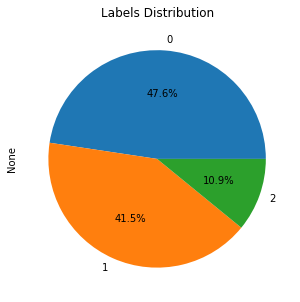

In [0]:
pd.Series(label).value_counts().plot(
    kind='pie', title='Labels Distribution', figsize=(5, 5),autopct='%1.1f%%')
plt.show()

**Figure 2. Claims word count distribution**

In [0]:
def articleLength(article):
  tokenizer = RegexpTokenizer(r'\w+')  
  article = article.replace("\n"," ").replace("\\","")
  article_words = tokenizer.tokenize(article)
  length = len(article_words)

  return length

In [0]:
# Visualize words count distribution of articles
word_count = []

for i in all_articles.values():
  word_count.append(articleLength(i))

In [0]:
c_length = []
for c in claims:
  c_length.append(articleLength(c['claim']))

Text(0, 0.5, 'frequency (Log scale)')

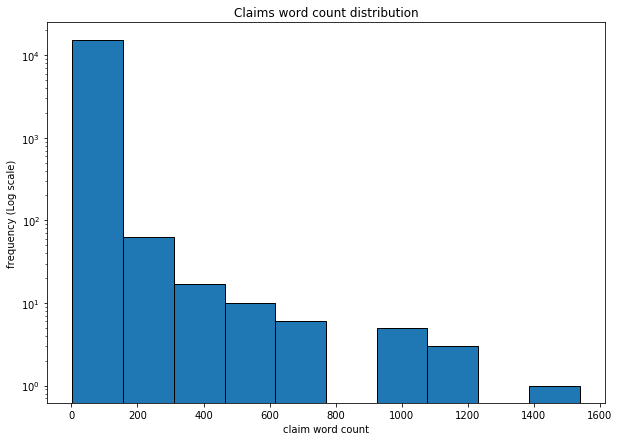

In [0]:
plt.figure(figsize=(10,7))
plt.hist(c_length, edgecolor='black')
plt.yscale("log")
plt.title("Claims word count distribution")
plt.xlabel("claim word count")
plt.ylabel("frequency (Log scale)")

**Figure 3. Correlation between claim length and truthness**

Text(0.5, 0, 'length of claims')

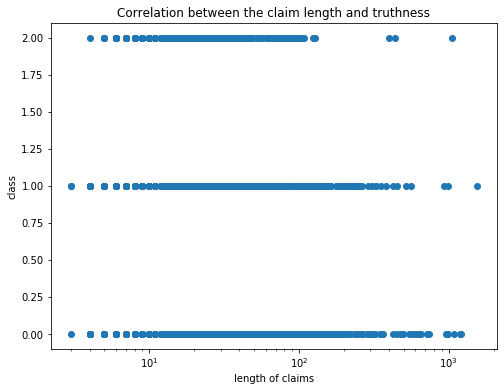

In [0]:
# Correlation btw claims and scales
y = label
x = c_length
fig = plt.figure(figsize=(8,6))
plt.plot(x, y,"o")
plt.title("Correlation between the claim length and truthness")
plt.ylabel('class')
plt.xscale('log')
plt.xlabel('length of claims')

There is negative correlation between length of claim and how true the claim is. The longer the claim, the faker it is.

**Word Clouds for different claim classes**

A word cloud is a novelty visual representation of text data, typically used to depict keywords or to visualize free form text. The importance of each keyword is shown with font size or color. This format is useful for quickly perceiving the most prominent terms.
We will visualize clouds depicting important keywords/tags for Fake, Partially True, and True claims separately.


In [0]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
#stopwordsList=open('stop_words.txt', 'r').read().split('\n')
stopwords.update(['say',
'says',
'said',
'see',
'state',
'year',
'years',
'percent',
'time',
'example',
'people',
'would',
'one',
'million'])
df_claim=pd.DataFrame.from_dict(claims)

True Claims

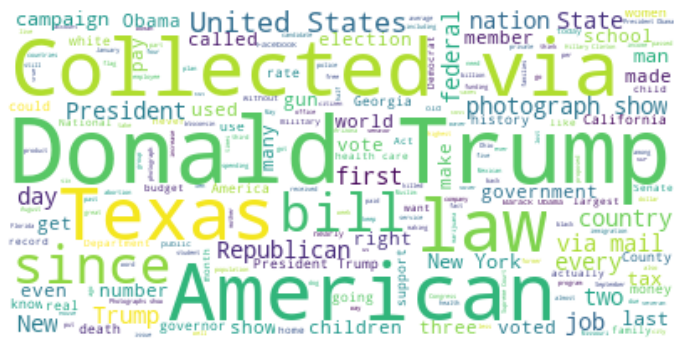

In [0]:
# Wordcloud beautification for True claims
from wordcloud import WordCloud
true_word_tokens = pd.Series(
    df_claim[df_claim['label'] == 2].claim.tolist()).str.cat(sep=' ')
true_word_tokens.lower()
wordcloud = WordCloud(max_font_size=100, stopwords=stopwords, random_state=None, background_color='white').generate(true_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Fake Claims

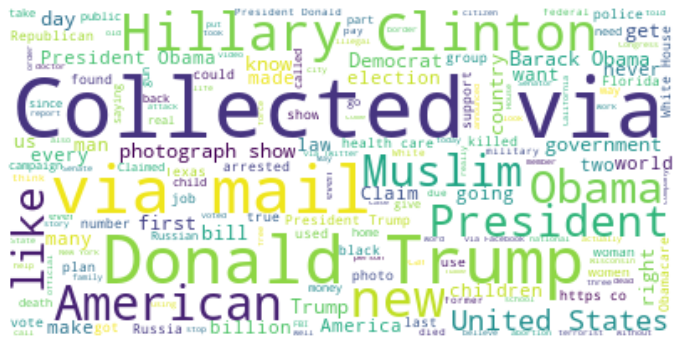

In [0]:
# Wordcloud beautification for Fake news
from wordcloud import WordCloud
true_word_tokens = pd.Series(
    df_claim[df_claim['label'] == 0].claim.tolist()).str.cat(sep=' ')

wordcloud = WordCloud(max_font_size=100, stopwords=stopwords, random_state=None, background_color='white').generate(true_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Partly True Claims

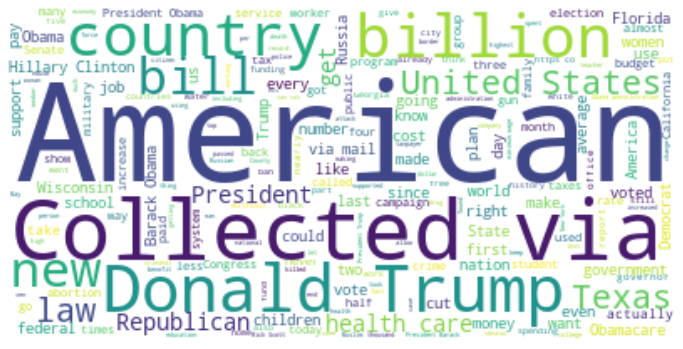

In [0]:
# Wordcloud beautification for partially true news
from wordcloud import WordCloud
true_word_tokens = pd.Series(
    df_claim[df_claim['label'] == 1].claim.tolist()).str.cat(sep=' ')

true_word_tokens.lower()

wordcloud = WordCloud(max_font_size=100, stopwords=stopwords, random_state=None, background_color='white').generate(true_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data Preprocessing

In [0]:
# input: string of article content, output: list of lines in article
def tosentences(article):
  sentence_list = sent_tokenize(article)
  sentence_list = list(filter(None,sentence_list))

  return sentence_list

In [0]:
# input: string of article content, output: list of cleaned words
def cleandata(article):
  tokenizer = RegexpTokenizer(r'\w+')
  wnLemm = WordNetLemmatizer()
  stop_words = set(stopwords.words('english'))
  
  article = article.replace("\n"," ").replace("\\","")
  article_words = tokenizer.tokenize(article)
  article_words = [w.lower() for w in article_words] # add lowercase 
  article_words = [wnLemm.lemmatize(w,'v') for w in article_words] # add lemmatizer           
  article_words = [w for w in article_words if not w in stop_words] # remove stop word

  return article_words

In [0]:
# input: string of claim sentence & list of sentences from article, output: tfidf dataframe
def tfidfsentence(article_list):
  claim = article_list[0]
  features = list(dict.fromkeys(claim))
  vectorizer = TfidfVectorizer(stop_words='english')
  X = vectorizer.fit_transform(article_list)
  X = X.toarray()
  tfidfdf = pd.DataFrame(np.round(X,2),columns=vectorizer.get_feature_names())
  
  return tfidfdf

In [0]:
# new cossim function, return the list of 5 top related sentences with highest cosine similarities
def top5cossim(article_list):
  senlist=[]
  cosines = []
  df_tfidf = tfidfsentence(article_list)
  claim = df_tfidf.iloc[0]

  for index in range(1,len(article_list)):
    sentvec = df_tfidf.iloc[index].values
    cosines.append(cosine_similarity([sentvec],[claim]))
  cosines = np.concatenate(np.concatenate(cosines, axis=0), axis=0)
  cosines=pd.DataFrame(cosines)
  cosines.columns=['cosine']
  
  top5index = list(cosines.iloc[cosines.cosine.argsort()[::-1][:5]].index+1) # plus one because of the claim at index 0
  for a in top5index:
    senlist.append(article_list[a])

  return senlist

In [0]:
# take ~2h to run
# save top 5 most related sentences from related articles into a dictionary for each claims
related_sentences = dict.fromkeys(range(len(claims)), []) 
for ii in range(len(claims)): # change to range(len(claims))
  articles = claims[ii]["related_articles"]
  allrelated = ''
  for articleid in articles:
    allrelated=allrelated+'\n'+all_articles[str(articleid)] # read all the related articles

  claim = claims[ii]["claim"]
  allrelated = allrelated.replace("\n"," ").replace(":",".").replace(";",".")
  sentence_list=tosentences(allrelated)
  sentence_list.insert(0, claim)  # insert the claim to index 0

  related_sentences[ii]=top5cossim(sentence_list) # append the list of related sentences into the dictionary